In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from Utils.build_dataset import paths_dataset_shrimp
from torchvision import transforms
from Models.unet_model import UNet
from Utils.FishDataset import FishDataset
from Utils.training import training_loop, predict, iou_np
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda:0


In [3]:
label_dict = {0 : "Black Sea Sprat", 1 : "Sea Bass", 2 : "Red Mullet", 3 : "Trout", 4 : "Striped Red Mullet", 
              5 : "Shrimp", 6 : "Red Sea Bream", 7 : "Hourse Mackerel", 8 : "Gilt-Head Bream"}

## Carregando as Imagens

In [4]:
path = 'Dataset/Fish_Dataset/Fish_Dataset/Shrimp/'
df_train_pd, df_valid_pd, df_test_pd = paths_dataset_shrimp(path)

In [5]:
img_size = 256
threshold = 0.5
transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize((img_size, img_size)), transforms.ToTensor()])

In [6]:
df_train = FishDataset(df_train_pd, transforms, transforms)

In [7]:
df_valid = FishDataset(df_valid_pd, transforms, transforms)

In [8]:
df_test = FishDataset(df_test_pd, transforms, transforms)

In [9]:
df_train[0][1].shape

torch.Size([1, 256, 256])

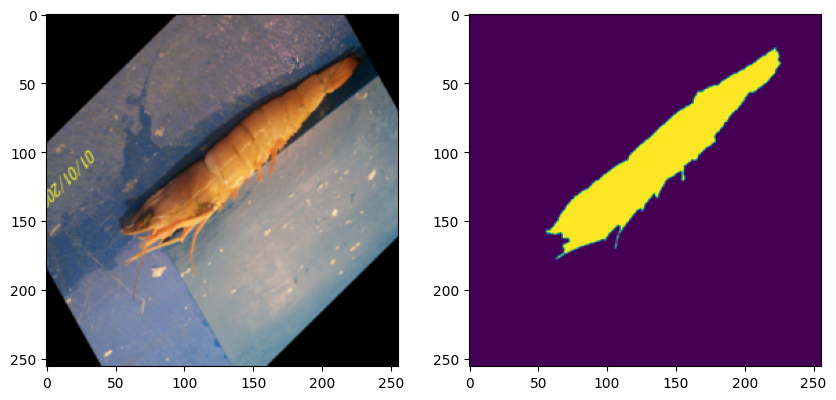

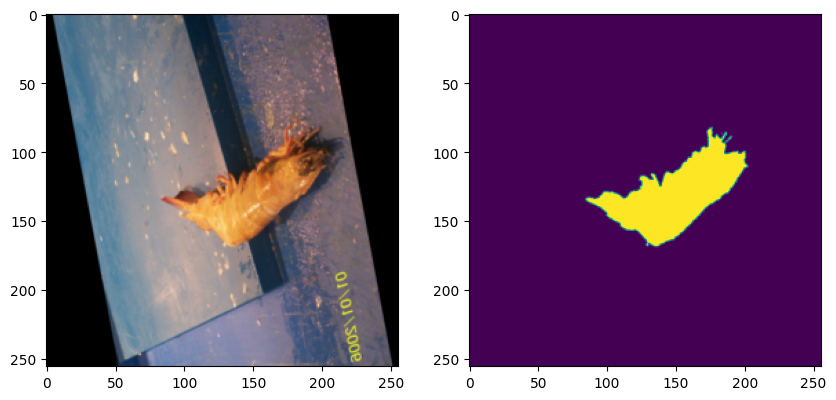

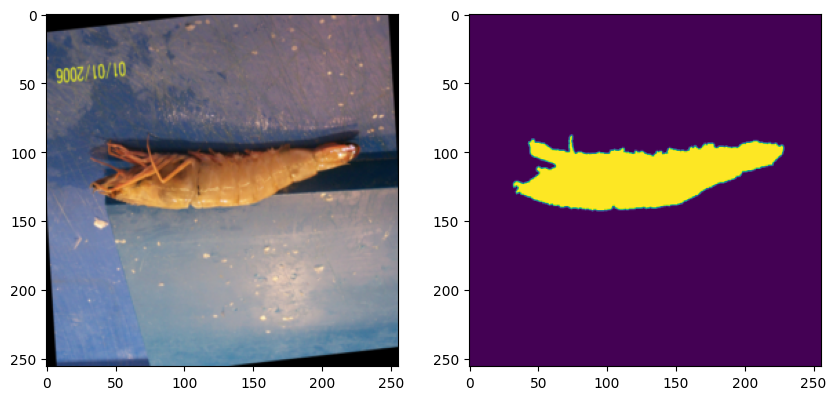

In [10]:
for i in range(3):
    n = random.randint(0, (len(df_train)))
    fig = plt.figure(figsize=(10, 100))
    
    fig.add_subplot(15, 2, 1)
    #plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][0].permute(1, 2, 0))
    
    fig.add_subplot(15, 2, 2)
    #plt.title(label_dict[df_train[n][2]])
    plt.imshow(df_train[n][1].permute(1, 2, 0))

## Construindo o Modelo

In [11]:
model = UNet(outSize = (img_size, img_size))
model.to(device, dtype=dtype)

UNet(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), str

In [12]:
epochs = 30
batch_size = 32
lr = 1e-3
train_loader = DataLoader(df_train, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(df_valid, batch_size=batch_size, shuffle=False, num_workers=4)
criterion = torch.nn.BCEWithLogitsLoss()
sigmoid = torch.nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [13]:
len(train_loader.dataset)

600

In [14]:
model, optimizer, train_losses, valid_losses, train_iou_list, valid_iou_list = training_loop(epochs, model, train_loader, valid_loader, criterion, optimizer, device, dtype)

Epoch 1 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.07s/it]


Train loss: 0.5385	Valid loss: 0.3201	Train IoU: 0.00	Valid IoU: 0.00
Epoch 2 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.32it/s]


Train loss: 0.1897	Valid loss: 0.0811	Train IoU: 0.00	Valid IoU: 2.98
Epoch 3 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.38it/s]


Train loss: 0.0694	Valid loss: 0.0611	Train IoU: 71.17	Valid IoU: 76.83
Epoch 4 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.36it/s]


Train loss: 0.0573	Valid loss: 0.0566	Train IoU: 75.29	Valid IoU: 74.40
Epoch 5 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.32it/s]


Train loss: 0.0544	Valid loss: 0.0553	Train IoU: 74.73	Valid IoU: 73.07
Epoch 6 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.31it/s]


Train loss: 0.0537	Valid loss: 0.0557	Train IoU: 74.74	Valid IoU: 72.60
Epoch 7 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.35it/s]


Train loss: 0.0531	Valid loss: 0.0537	Train IoU: 74.86	Valid IoU: 75.80
Epoch 8 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.33it/s]


Train loss: 0.0522	Valid loss: 0.0526	Train IoU: 74.58	Valid IoU: 74.26
Epoch 9 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.37it/s]


Train loss: 0.0514	Valid loss: 0.0518	Train IoU: 74.94	Valid IoU: 75.55
Epoch 10 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.29it/s]


Train loss: 0.0505	Valid loss: 0.0520	Train IoU: 74.73	Valid IoU: 75.49
Epoch 11 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.32it/s]


Train loss: 0.0503	Valid loss: 0.0509	Train IoU: 75.17	Valid IoU: 73.27
Epoch 12 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.33it/s]


Train loss: 0.0499	Valid loss: 0.0510	Train IoU: 74.73	Valid IoU: 73.19
Epoch 13 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.33it/s]


Train loss: 0.0499	Valid loss: 0.0511	Train IoU: 74.93	Valid IoU: 76.59
Epoch 14 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.31it/s]


Train loss: 0.0498	Valid loss: 0.0531	Train IoU: 74.69	Valid IoU: 78.44
Epoch 15 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.35it/s]


Train loss: 0.0500	Valid loss: 0.0522	Train IoU: 75.09	Valid IoU: 77.67
Epoch 16 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.32it/s]


Train loss: 0.0498	Valid loss: 0.0508	Train IoU: 75.08	Valid IoU: 73.09
Epoch 17 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.31it/s]


Train loss: 0.0491	Valid loss: 0.0531	Train IoU: 75.27	Valid IoU: 72.78
Epoch 18 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.34it/s]


Train loss: 0.0497	Valid loss: 0.0501	Train IoU: 75.22	Valid IoU: 73.55
Epoch 19 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.33it/s]


Train loss: 0.0489	Valid loss: 0.0503	Train IoU: 75.17	Valid IoU: 73.58
Epoch 20 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.32it/s]


Train loss: 0.0485	Valid loss: 0.0500	Train IoU: 75.42	Valid IoU: 75.57
Epoch 21 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.36it/s]


Train loss: 0.0482	Valid loss: 0.0496	Train IoU: 75.16	Valid IoU: 76.07
Epoch 22 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.33it/s]


Train loss: 0.0482	Valid loss: 0.0515	Train IoU: 75.54	Valid IoU: 73.35
Epoch 23 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.34it/s]


Train loss: 0.0485	Valid loss: 0.0505	Train IoU: 75.44	Valid IoU: 73.16
Epoch 24 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.37it/s]


Train loss: 0.0482	Valid loss: 0.0504	Train IoU: 75.40	Valid IoU: 74.69
Epoch 25 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.34it/s]


Train loss: 0.0479	Valid loss: 0.0508	Train IoU: 75.17	Valid IoU: 77.20
Epoch 26 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.33it/s]


Train loss: 0.0486	Valid loss: 0.0500	Train IoU: 75.52	Valid IoU: 76.32
Epoch 27 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.38it/s]


Train loss: 0.0479	Valid loss: 0.0494	Train IoU: 75.40	Valid IoU: 74.98
Epoch 28 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.33it/s]


Train loss: 0.0475	Valid loss: 0.0499	Train IoU: 75.43	Valid IoU: 76.09
Epoch 29 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:14<00:00,  1.35it/s]


Train loss: 0.0477	Valid loss: 0.0513	Train IoU: 75.53	Valid IoU: 77.15
Epoch 30 out of 30


100%|████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.38it/s]


Train loss: 0.0480	Valid loss: 0.0495	Train IoU: 75.35	Valid IoU: 75.69


In [15]:
torch.save(model.state_dict(), "Saved Models/unet_shrimp.pkl")

### Carregando Modelo

In [12]:
model.load_state_dict(torch.load("Saved Models/unet_shrimp.pkl"))

<All keys matched successfully>

## Avaliando o Modelo

In [16]:
test_loader = DataLoader(df_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [17]:
model.eval()
model.to(device)

UNet(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), str

In [18]:
img_list_test = list(df_test_pd['image'])
mask_list_test = list(df_test_pd['mask'])

In [19]:
running_iou = 0

for i in range(len(img_list_test)):
    image = cv2.imread(img_list_test[i])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[i])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    iou_pred = iou_np(mask, pred)
    running_iou += iou_pred

iou_test = (running_iou / len(img_list_test)) * 100
print(f'IoU: {iou_test:.1f}')

IoU: 80.3


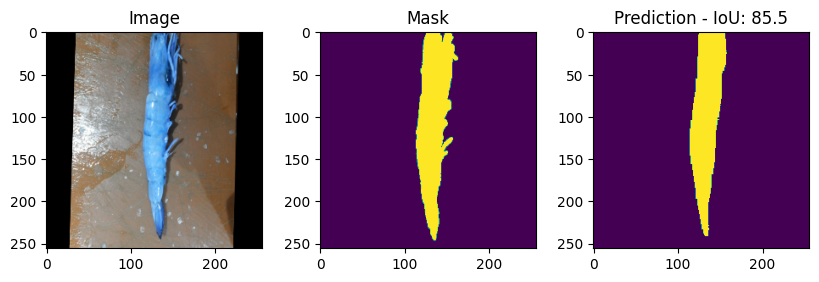

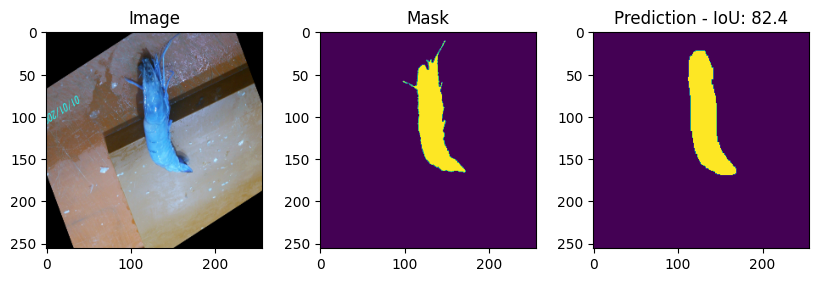

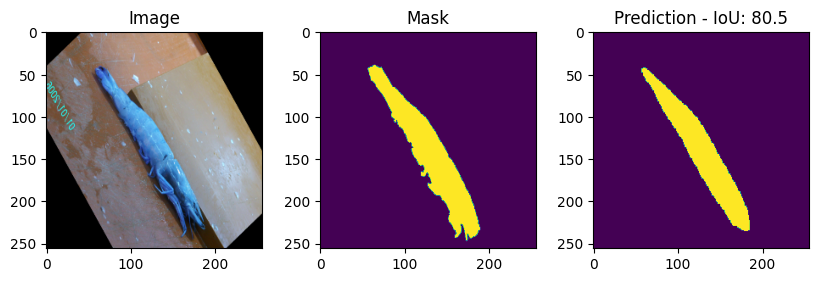

In [20]:
for i in range(3):
    n = random.randint(0, (len(img_list_test)))
    fig = plt.figure(figsize=(10, 50))
    
    image = cv2.imread(img_list_test[n])
    image = cv2.resize(image, (img_size, img_size))
    mask = cv2.imread(mask_list_test[n])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (img_size, img_size))
    pred = predict(model, image, img_size, threshold, device)
    iou = iou_np(mask, pred) * 100
    
    
    fig.add_subplot(15, 3, 1)
    plt.title('Image')
    plt.imshow(image)
    
    fig.add_subplot(15, 3, 2)
    plt.title('Mask')
    plt.imshow(mask)
    
    fig.add_subplot(15, 3, 3)
    plt.title(f'Prediction - IoU: {iou:.1f}')
    plt.imshow(pred)